In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy_ext import rolling_apply

from qtrader.core.security import Security, Futures
from qtrader.core.constants import Exchange
from qtrader.core.data import _get_data
from qtrader.plugins.analysis.metrics import sharpe_ratio
from qtalib.indicators import CYC, SAR
from qtrader_config import *

In [2]:
def load_data(
        security: Security,
        data_start: datetime,
        start: datetime,
        end: datetime,
        lookback_period: int = None
) -> pd.DataFrame:
    """Load OHLCV"""
    data = _get_data(
        security=security,
        start=data_start,
        end=end,
        dfield="kline",
        dtype=['time_key', 'open', 'high', 'low', 'close', 'volume']
    ).set_index("time_key")
    data = data.ffill().bfill()
    if data[data.index <= start].shape[0] < lookback_period:
        raise ValueError("There is not enough lookback data, change data_start")
    ret_data = pd.concat(
        [data[data.index <= start].iloc[-lookback_period:],
         data[data.index > start]]
    )
    return ret_data

In [3]:
security = Futures(
    code="HK.MHImain",
    lot_size=50,
    security_name="HK.MHImain",
    exchange=Exchange.HKFE,
    expiry_date="20221231"
)

# data_start = datetime(2020, 11, 15, 0, 0, 0)
# start = datetime(2021, 2, 1, 0, 0, 0)
# end = datetime(2022, 12, 1, 23, 59, 59)
# lookback_window = 194

data_start = datetime(2021, 1, 1, 0, 0, 0)
start = datetime(2022, 1, 1, 0, 0, 0)
end = datetime(2022, 10, 15, 23, 59, 59)
data_lookback_window = 350

# Load data
data = load_data(security, data_start, start, end, data_lookback_window)


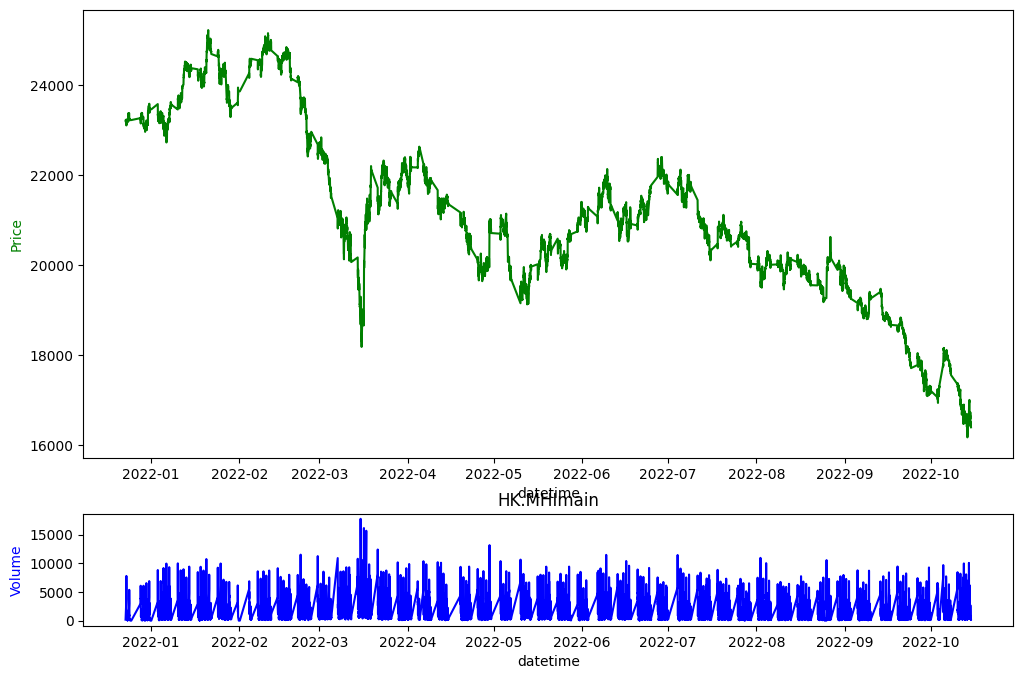

In [5]:
fig, (ax1, ax2) = plt.subplots(
    2, figsize=(12,8), gridspec_kw={'height_ratios': [4, 1]})
ax1.plot(data.index, data.close, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='g')
ax2.plot(data.index, data.volume, 'b-')
ax2.set_xlabel('datetime')
ax2.set_ylabel('Volume', color='b')
plt.title(security.code)
plt.show()

In [6]:
cyc = {
    "close": 0,
    "volume": 0
}
PCY = []
VOC = []
SAR_lst = []
for idx in range(data_lookback_window, data.shape[0]):
    data_lb = data.iloc[idx-data_lookback_window+1:idx+1]
    highs = data_lb["high"].to_numpy(dtype=float)
    lows = data_lb["low"].to_numpy(dtype=float)
    closes = data_lb["close"].to_numpy(dtype=float)
    volumes = data_lb["volume"].to_numpy(dtype=float)
    cyc["close"] = CYC(
        data=closes,
        cyc=cyc["close"],
        short_ma_length=15,
        long_ma_length=25,
        alpha=0.41,
        lookback_window=15,
    )
    PCY.append(cyc["close"])
    cyc["volume"] = CYC(
        data=volumes,
        cyc=cyc["volume"],
        short_ma_length=13,
        long_ma_length=25,
        alpha=0.26,
        lookback_window=30,
    )
    VOC.append(cyc["volume"])
    sar = SAR(
        highs[-14:],
        lows[-14:]
    )[-1]
    SAR_lst.append(sar)

In [7]:
data_bt = data.iloc[data_lookback_window:].copy()
data_bt["VOC"] = VOC
data_bt["PCY"] = PCY
data_bt["SAR"] = SAR_lst

## Correlation

Check Pearson correlation between PCY and prices

In [8]:
def corr(x, y):
    return np.corrcoef(x, y)[0][1]

In [9]:
n = len(data_bt) // 3
rolling_corr_pcy = rolling_apply(
    corr,
    n,
    data_bt.PCY.diff().apply(lambda x: np.sign(x)).dropna().values,
    data_bt.close.diff().apply(lambda x: np.sign(x)).dropna().values
)
rolling_corr_pcy = rolling_corr_pcy[~np.isnan(rolling_corr_pcy)]

Check correlation between VOC and volumes

In [10]:
n = len(data_bt) // 3
rolling_corr_voc = rolling_apply(
    corr,
    n,
    data_bt.VOC.diff().apply(lambda x: np.sign(x)).dropna().values,
    data_bt.volume.diff().apply(lambda x: np.sign(x)).dropna().values
)
rolling_corr_voc = rolling_corr_voc[~np.isnan(rolling_corr_voc)]


In [11]:
print(
    f"VOC range: [{data_bt['VOC'].min()}, {data_bt['VOC'].max()}]\n"
    f"Correlation(VOC, price_trends): "
    f"[{rolling_corr_voc.min()}, {rolling_corr_voc.max()}],"
    f"mean={rolling_corr_voc.mean()}\n"
    f"PCY range: [{data_bt['PCY'].min()}, {data_bt['PCY'].max()}]\n"
    f"Correlation(PCY, price): "
    f"[{rolling_corr_pcy.min()}, {rolling_corr_pcy.max()}],"
    f"mean={rolling_corr_pcy.mean()}\n"
)


VOC range: [0.30544767687911584, 99.99972806873443]
Correlation(VOC, price_trends): [-0.06802808358292879, -0.028993303710898453],mean=-0.048262671127524824
PCY range: [3.400407614807681e-05, 99.99999955261956]
Correlation(PCY, price): [0.036218669639872796, 0.08620513337756884],mean=0.06258371830007967



buy & sell signals

In [12]:
pcy_mean = data_bt.PCY.mean()
pcy_std = data_bt.PCY.std()
voc_mean = data_bt.VOC.mean()
voc_std = data_bt.VOC.std()
print(
    f"PCY mean: {pcy_mean}; PCY std: {pcy_std}\n"
    f"VOC mean: {voc_mean}; VOC std: {voc_std}"
)

PCY mean: 49.508881971416926; PCY std: 40.36665561748386
VOC mean: 51.184612650594154; VOC std: 34.612010708416044


In [13]:
# VOC bottom, PCY bottom
pcy_entry_long_threshold = 10
data_bt["entry_long"] = rolling_apply(
    lambda PCY: int(
        PCY[0] >= PCY[1]
        and PCY[1] <= PCY[2]
        and PCY[1] < pcy_entry_long_threshold
    ),
    3,
    data_bt.PCY.values
)

# VOC bottom, PCY top
pcy_entry_short_threshold = 90
data_bt["entry_short"] = rolling_apply(
    lambda PCY: int(
        PCY[0] <= PCY[1]
        and PCY[1] >= PCY[2]
        and PCY[1] > pcy_entry_short_threshold
    ),
    3,
    data_bt.PCY.values
)

pcy_exit_long_threshold = 90
voc_exit_long_threshold = 20
data_bt["exit_long"] = rolling_apply(
    lambda VOC, PCY, close_: int(
        close_[0] <= close_[1]
        and close_[1] >= close_[2]
        and PCY[1] > pcy_exit_long_threshold
        and VOC[1] < voc_exit_long_threshold
    ),
    3,
    data_bt.VOC.values,
    data_bt.PCY.values,
    data_bt.close.values
)

pcy_exit_short_threshold = 10
voc_exit_short_threshold = 20
data_bt["exit_short"] = rolling_apply(
    lambda VOC, PCY, close_: int(
        close_[0] >= close_[1]
        and close_[1] <= close_[2]
        and PCY[1] < pcy_exit_short_threshold
        and VOC[1] < voc_exit_short_threshold
    ),
    3,
    data_bt.VOC.values,
    data_bt.PCY.values,
    data_bt.close.values
)

In [18]:
data_bt_plot = data_bt[
    (data_bt.index > datetime(2022, 1, 4))
    & (data_bt.index < datetime(2022, 1, 6))
]
data_bt_plot_entry_long = data_bt_plot[data_bt_plot.entry_long==1]
data_bt_plot_exit_long = data_bt_plot[data_bt_plot.exit_long==1]
data_bt_plot_entry_short = data_bt_plot[data_bt_plot.entry_short==1]
data_bt_plot_exit_short = data_bt_plot[data_bt_plot.exit_short==1]

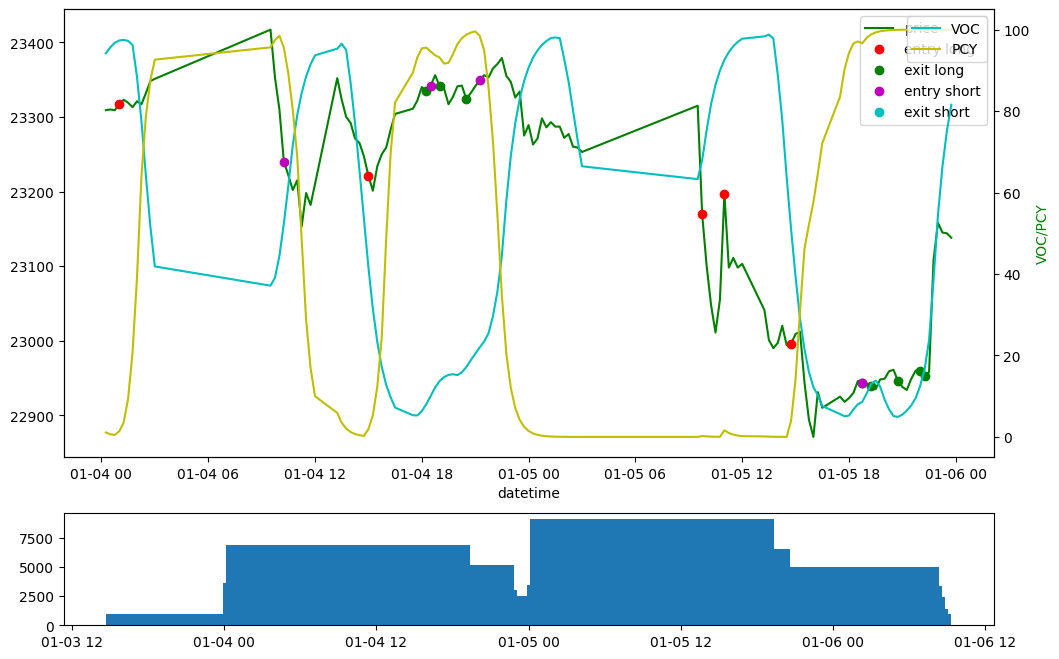

In [19]:
fig, (ax1, ax3) = plt.subplots(
    2, figsize=(12,8), gridspec_kw={'height_ratios': [4, 1]})
ax2 = ax1.twinx()
ax1.plot(data_bt_plot.index, data_bt_plot.close, 'g-', label='price')
ax1.plot(data_bt_plot_entry_long.index,
         data_bt_plot_entry_long.close, 'ro', label='entry long')
ax1.plot(data_bt_plot_exit_long.index,
         data_bt_plot_exit_long.close, 'go', label='exit long')
ax1.plot(data_bt_plot_entry_short.index,
         data_bt_plot_entry_short.close, 'mo', label='entry short')
ax1.plot(data_bt_plot_exit_short.index,
         data_bt_plot_exit_short.close, 'co', label='exit short')
ax2.plot(data_bt_plot.index, data_bt_plot.VOC, 'c-', label='VOC')
ax2.plot(data_bt_plot.index, data_bt_plot.PCY, 'y-', label='PCY')
ax1.legend(loc=0)
ax2.legend(loc=1)
ax1.set_xlabel('datetime')
ax2.set_ylabel('Price', color='b')
ax2.set_ylabel('VOC/PCY', color='g')
ax3.bar(data_bt_plot.index, data_bt_plot.volume, label='volume')

plt.show()


Long only

In [108]:
entry_long_signal = "entry_long"
exit_long_signal = "exit_long"
pos = 0
open_time_lst = []
cost_lst = []
trades = []
stop_trades = []
pnls = []
for i in range(len(data_bt)):
    row = data_bt.iloc[i]
    dt = data_bt.index[i]
    pnl = 0
    # update pnl
    for idx, cost in enumerate(cost_lst):
        prev_row = data_bt.iloc[i-1]
        pnl += (row.close - prev_row.close) / cost
    if row[entry_long_signal] == 1:
        if pos == 0:
            pos += 1
            cost_lst.append(row.close)
            open_time_lst.append(dt)
        elif pos > 0:
            lowest_cost = min(cost_lst)
            if True: # row.close < lowest_cost:
                pos += 1
                cost_lst.append(row.close)
                open_time_lst.append(dt)
        else:
            raise ValueError("Long only should not have short position!")
    elif pos > 0:
        # SAR stop loss
        if row[exit_long_signal]: # or row.SAR > row.close:
            print(dt, len(cost_lst), row.SAR > row.close, row[exit_long_signal])
            for idx, cost in enumerate(cost_lst):
                pos -= 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            cost_lst = []
            open_time_lst = []
    pnls.append(pnl)
data_bt["equity"] = np.cumsum(pnls)

2018-05-15 00:00:00 3 False 1.0
2018-08-10 00:00:00 3 True 1.0
2018-11-23 00:00:00 1 False 1.0
2019-02-14 00:00:00 1 False 1.0
2019-04-18 00:00:00 2 False 1.0
2019-09-05 00:00:00 2 False 1.0
2020-04-20 00:00:00 6 False 1.0
2020-08-31 00:00:00 2 False 1.0
2020-10-27 00:00:00 1 False 1.0
2021-04-26 00:00:00 4 False 1.0
2021-08-26 00:00:00 4 True 1.0
2021-10-26 00:00:00 1 False 1.0


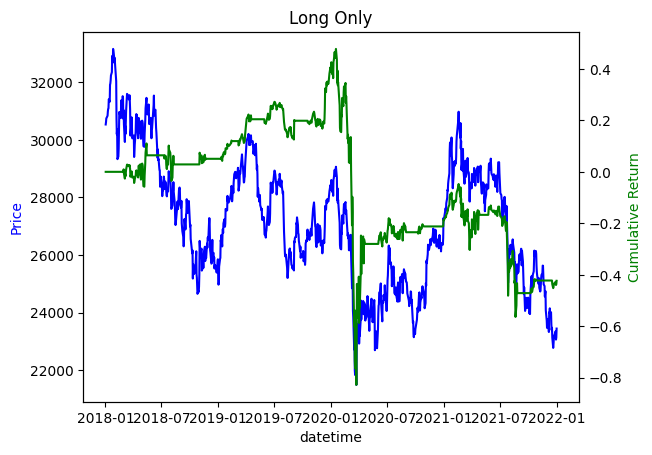

In [109]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_bt.index, data_bt.close, 'b-')
ax2.plot(data_bt.index, data_bt.equity, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='b')
ax2.set_ylabel('Cumulative Return', color='g')
plt.title("Long Only")
plt.show()

In [110]:
num_trades = len(trades)
num_stop_trades = len(stop_trades)
trades_pnl = [t[-1] for t in trades]
win_trades_pnl = [t[-1] for t in trades if t[-1]>0]
num_win_trades = len(win_trades_pnl)
lose_trades_pnl = [t[-1] for t in trades if t[-1]<=0]
num_lose_trades = len(lose_trades_pnl)
stop_trades_pnl = [t[-1] for t in stop_trades]
df_daily = data_bt.resample('D').agg(
    {"equity": "last"}).dropna()
sr = sharpe_ratio(
    returns=df_daily["equity"].diff().dropna(),
    days=252
)
total_return = df_daily.iloc[-1]["equity"]
annual_return = total_return * 252 / df_daily.shape[0]

In [111]:
print(
    "________ <Long Only> ________\n"
    f"number of trades: {num_trades}\n"
    f"number of stop trades: {num_stop_trades}\n"
    f"number of win trades: {num_win_trades}\n"
    f"number of lose trades: {num_lose_trades}\n"
    f"win trade ratio: {num_win_trades/num_trades}\n"
    f"maximum win trade: {max(trades_pnl)}\n"
    f"maximum lose trade: {min(trades_pnl)}\n"
    f"Sharpe ratio: {sr}\n"
    f"Total return: {total_return}\n"
    f"annual_return: {annual_return}\n"
)

________ <Long Only> ________
number of trades: 30
number of stop trades: 30
number of win trades: 14
number of lose trades: 16
win trade ratio: 0.4666666666666667
maximum win trade: 0.08824967099078775
maximum lose trade: -0.12567518905293482
Sharpe ratio: -0.22080495760633714
Total return: -0.4233344545906556
annual_return: -0.10786681754989405



In [20]:
trades

[[Timestamp('2018-02-28 00:00:00'),
  Timestamp('2018-06-12 00:00:00'),
  0.0100872055186776],
 [Timestamp('2018-04-17 00:00:00'),
  Timestamp('2018-06-12 00:00:00'),
  0.03283979371152886],
 [Timestamp('2018-04-23 00:00:00'),
  Timestamp('2018-06-12 00:00:00'),
  0.026419336706014616],
 [Timestamp('2018-07-10 00:00:00'),
  Timestamp('2018-10-18 00:00:00'),
  -0.11328656685163857],
 [Timestamp('2018-07-12 00:00:00'),
  Timestamp('2018-10-18 00:00:00'),
  -0.10811949310211676],
 [Timestamp('2018-07-16 00:00:00'),
  Timestamp('2018-10-18 00:00:00'),
  -0.10883900385829534],
 [Timestamp('2018-11-01 00:00:00'),
  Timestamp('2018-12-18 00:00:00'),
  0.01886196827401152],
 [Timestamp('2019-01-09 00:00:00'),
  Timestamp('2019-02-22 00:00:00'),
  0.08640392230812748],
 [Timestamp('2019-03-07 00:00:00'),
  Timestamp('2019-07-18 00:00:00'),
  -0.010305330223166103],
 [Timestamp('2019-03-28 00:00:00'),
  Timestamp('2019-07-18 00:00:00'),
  -0.010167484940283435],
 [Timestamp('2019-05-30 00:00:00'

Long Short

In [21]:
entry_long_signal = "entry_long"
entry_short_signal = "entry_short"
exit_long_signal = "exit_long"
exit_short_signal = "exit_short"
pos = 0
open_time_lst = []
cost_lst = []
trades = []
stop_trades = []
pnls = []
for i in range(len(data_bt)):
    row = data_bt.iloc[i]
    dt = data_bt.index[i]
    pnl = 0
    # update pnl
    for idx, cost in enumerate(cost_lst):
        prev_row = data_bt.iloc[i-1]
        if pos > 0:
            pnl += (row.close - prev_row.close) / cost
        else:
            pnl += -(row.close - prev_row.close) / cost

    if row[entry_long_signal] == 1:
        # close short
        if pos < 0:
            for idx, cost in enumerate(cost_lst):
                pos += 1
                close_time = dt
                open_time = open_time_lst[idx]
                prev_row = data_bt.iloc[i-1]
                cum_pnl = -(row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            assert pos == 0, "position incorrect"
            cost_lst = []
            open_time_lst = []
        # open long
        elif pos == 0:
            pos += 1
            cost_lst.append(row.close)
            open_time_lst.append(dt)
        elif pos > 0:
            lowest_cost = min(cost_lst)
            if True: # row.close < lowest_cost:
                pos += 1
                cost_lst.append(row.close)
                open_time_lst.append(dt)
    elif row[entry_short_signal] == 1:
        # close long
        if pos > 0:
            for idx, cost in enumerate(cost_lst):
                pos -= 1
                close_time = dt
                open_time = open_time_lst[idx]
                prev_row = data_bt.iloc[i-1]
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            assert pos == 0, "position incorrect"
            cost_lst = []
            open_time_lst = []
        # open short
        elif pos == 0:
            pos -= 1
            cost_lst.append(row.close)
            open_time_lst.append(dt)
        elif pos < 0:
            highest_cost = max(cost_lst)
            if True: # row.close > highest_cost:
                pos -= 1
                cost_lst.append(row.close)
                open_time_lst.append(dt)
    elif pos > 0:
        # SAR stop loss
        if row[exit_long_signal]:  # or row.SAR > row.close:
            for idx, cost in enumerate(cost_lst):
                pos -= 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                cum_pnl = (row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            cost_lst = []
            open_time_lst = []
    elif pos < 0:
        # SAR stop loss
        if row[exit_short_signal]:  # or row.SAR < row.close:
            for idx, cost in enumerate(cost_lst):
                pos += 1
                open_time = open_time_lst[idx]
                close_time = dt
                prev_row = data_bt.iloc[i-1]
                cum_pnl = -(row.close - cost) / cost
                trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
                stop_trades.append([
                    open_time,
                    close_time,
                    cum_pnl
                ])
            cost_lst = []
            open_time_lst = []
    pnls.append(pnl)
data_bt["equity"] = np.cumsum(pnls)

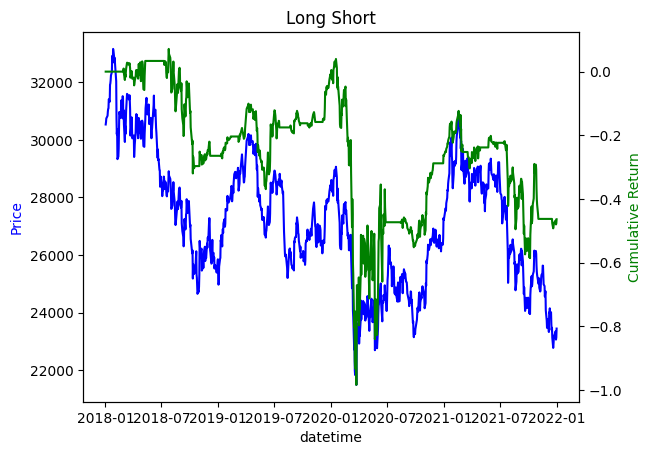

In [22]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data_bt.index, data_bt.close, 'b-')
ax2.plot(data_bt.index, data_bt.equity, 'g-')
ax1.set_xlabel('datetime')
ax1.set_ylabel('Price', color='b')
ax2.set_ylabel('Cumulative Return', color='g')
plt.title("Long Short")
plt.show()

In [23]:
num_trades = len(trades)
num_stop_trades = len(stop_trades)
trades_pnl = [t[-1] for t in trades]
win_trades_pnl = [t[-1] for t in trades if t[-1]>0]
num_win_trades = len(win_trades_pnl)
lose_trades_pnl = [t[-1] for t in trades if t[-1]<=0]
num_lose_trades = len(lose_trades_pnl)
stop_trades_pnl = [t[-1] for t in stop_trades]
df_daily = data_bt.resample('D').agg(
    {"equity": "last"}).dropna()
sr = sharpe_ratio(
    returns=df_daily["equity"].diff().dropna(),
    days=252
)
total_return = df_daily.iloc[-1]["equity"]
annual_return = total_return * 252 / df_daily.shape[0]

In [24]:
print(
    "________ <Long Short> ________\n"
    f"number of trades: {num_trades}\n"
    f"number of stop trades: {num_stop_trades}\n"
    f"number of win trades: {num_win_trades}\n"
    f"number of lose trades: {num_lose_trades}\n"
    f"win trade ratio: {num_win_trades/num_trades}\n"
    f"maximum win trade: {max(trades_pnl)}\n"
    f"maximum lose trade: {min(trades_pnl)}\n"
    f"Sharpe ratio: {sr}\n"
    f"Total return: {total_return}\n"
    f"annual_return: {annual_return}\n"
)


________ <Long Short> ________
number of trades: 30
number of stop trades: 9
number of win trades: 15
number of lose trades: 15
win trade ratio: 0.5
maximum win trade: 0.11368055268274521
maximum lose trade: -0.11753691033489377
Sharpe ratio: -0.22535048668036595
Total return: -0.46374370430994893
annual_return: -0.11816320878271702

